### Inverted Pendulum on cart


### System model
ref: https://www.researchgate.net/publication/273170289_Optimal_Control_of_Nonlinear_Inverted_Pendulum_System_Using_PID_Controller_and_LQR_Performance_Analysis_Without_and_With_Disturbance_Input

$\frac{\mathrm{d} \boldsymbol{x}}{\mathrm{d} t}=\frac{\mathrm{d}}{\mathrm{d} t}\left[\begin{array}{l}x_{1} \\ x_{2} \\ x_{3} \\ x_{4}\end{array}\right]=\frac{\mathrm{d}}{\mathrm{d} t}\left[\begin{array}{c}\theta \\ \dot{\theta} \\ x \\ \dot{x}\end{array}\right]=\left[\begin{array}{c}f_{1} \\ f_{2} \\ f_{3} \\ f_{4}\end{array}\right] = \left[\begin{array}{c} x_2\\ \frac{u \cos x_{1}-(M+m) g \sin x_{1}+m l\left(\cos x_{1} \sin x_{1}\right) x_{2}^{2}}{m l \cos ^{2} x_{1}-(M+m) l}  \\ x_4 \\ \frac{u+m l(\sin x_1) x_2^{2}-m g \cos x_1 \sin x_1}{M+m-m \cos ^{2} x_1} \end{array}\right]$

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def inverted_pendulum_nonlinear_ode(x, u):
    M  = 2.4
    m = 0.23
    l = 0.36
    g = 9.81

    dx1_dt = x[1]
    dx2_dt = ( u * ca.cos(x[0]) - (M+m) * g * ca.sin(x[0]) + m * l * ca.cos(x[0]) *ca.sin(x[0])*x[1]**2) / (m*l*ca.cos(x[0])**2 - (M+m) *l)
    dx3_dt = x[3]
    dx4_dt = (u + m*l * ca.sin(x[0]) * x[1]**2 - m*g*ca.cos(x[0])*ca.sin(x[0]))/(M+m-m*ca.cos(x[0])**2)
    rhs = [dx1_dt,
           dx2_dt,
           dx3_dt,
           dx4_dt
           ]
    
    return ca.vertcat(*rhs)

In [60]:
x_SX = ca.SX.sym("x_SX", 4)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [inverted_pendulum_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1
# N = 5

In [61]:
ode.sx_in()

[SX([x_SX_0, x_SX_1, x_SX_2, x_SX_3]), SX(u_SX)]

In [62]:
def integrator_rk4(f, x, u, delta_t):
    '''
    This function calculates the integration of stage cost with RK4.
    '''

    k1 = f(x, u)
    k2 = f(x + delta_t / 2 * k1, u)
    k3 = f(x + delta_t / 2 * k2, u)
    k4 = f(x + delta_t * k3, u)


    x_next = x + delta_t / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_next

In [63]:
sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

In [64]:
A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

In [65]:
x0 =  ca.SX.sym("x0_SX", 4)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 4)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0)
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

### Test 1: state evolution

(a) constant input u = 0, system evolves by only considering linear term $Ax_k + Bu_k$

In [66]:
N = 100

x_init = np.array([[0],[0],[0],[0]])


x_next = A_fn(x0,u0) @ xk +  B_fn(x0,u0) @ uk
x_next_fn = ca.Function("x_next_fn",[x0,xk,u0,uk],[x_next])

In [67]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

In [68]:
uk = np.array([[0.1]])
xk = x_init
for i in range(N):
    if i == 0:
        x0 = np.array([[0],[0],[0],[0]])
        u0 = uk
    
    x_next = x_next_fn(x0,xk,u0,uk)
    print(x_next)
    x_list1.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

[-0.000593104, -0.0121501, 0.000208787, 0.0041848]
[-0.00255245, -0.0280187, 0.000840815, 0.00848667]
[-0.00647744, -0.0524574, 0.00191495, 0.0130583]
[-0.0135685, -0.0929382, 0.00346899, 0.0181349]
[-0.0259939, -0.161833, 0.00557114, 0.0241049]
[-0.0475511, -0.280166, 0.00834065, 0.0316248]
[-0.0848191, -0.483894, 0.0119829, 0.0417973]
[-0.149122, -0.834096, 0.0168454, 0.0563895]
[-0.259748, -1.43159, 0.0234868, 0.0777693]
[-0.448605, -2.4278, 0.0326643, 0.106662]
[-0.76414, -3.98378, 0.0446936, 0.129333]
[-1.26302, -6.0415, 0.0560984, 0.0722855]
[-1.96972, -8.00644, 0.0504528, -0.244104]
[-2.83069, -8.77379, -0.00190152, -0.782338]
[-3.49536, -2.57905, -0.0749929, -0.376304]
[-3.13659, 9.06804, -0.0536362, 0.695034]
[-1.87753, 15.4257, 0.0226044, 0.794968]
[-0.154762, 17.72, 0.10802, 0.695697]
[1.69977, 20.4047, 0.107258, -0.426076]
[3.80762, 23.358, 0.2064, 2.62759]
[5.47158, 6.18735, 0.291563, -2.22599]
[6.60035, 18.6495, -0.0357094, -1.43812]
[9.30076, 37.4848, -0.185093, -1.61411

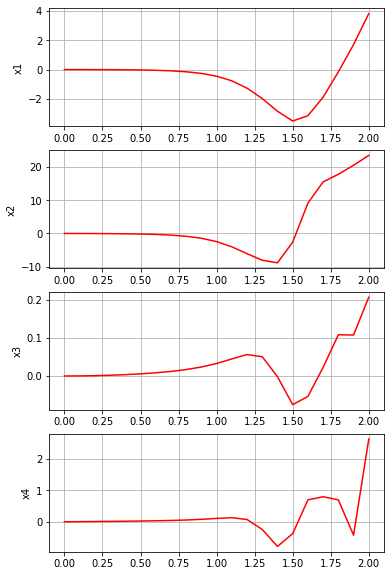

In [69]:
x_plot = np.array(x_list1)
N_plot = 20
tgrid = [delta_t * k for k in range(N_plot + 1)]
plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:N_plot+1,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [70]:
x_list2 = []
x_list2.append(x_init.flatten().tolist())

In [71]:
uk = np.array([[0.1]])
xk = x_init

for i in range(N):
    x_next = x_next_fn_lin(xk,xk,uk,uk)
#     print(x_next)
    x_list2.append(x_next.full().flatten().tolist())
    xk = x_next

In [72]:
x_plot = np.array(x_list1)
N_plot = 20
tgrid = [delta_t * k for k in range(N_plot + 1)]

In [73]:
x_list2

[[0, 0, 0, 0],
 [-0.0005931044726626505,
  -0.012150104508938298,
  0.0002087867103728716,
  0.004184801695032171],
 [-0.002552447119481473,
  -0.028018666873550924,
  0.0008408146015742454,
  0.008486668406303565],
 [-0.0064774377159006365,
  -0.052457289124416585,
  0.0019149536747618658,
  0.013058316142561898],
 [-0.013568471509037972,
  -0.09293772264389379,
  0.0034689868446849364,
  0.018134802121685244],
 [-0.02599374905020419,
  -0.16183109060212353,
  0.005571118807614058,
  0.024104584716047404],
 [-0.047550633114001165,
  -0.28016149033308313,
  0.008340578634003228,
  0.031623951762608994],
 [-0.08481777117633979,
  -0.48388110234781656,
  0.011982723112948304,
  0.04179486882771931],
 [-0.14911923655180678,
  -0.8340716557662979,
  0.016844757845026998,
  0.05638423252895748],
 [-0.2597444248282574,
  -1.4316514835761194,
  0.023485760284843584,
  0.07777334715096529],
 [-0.4486561730467257,
  -2.429612773234763,
  0.03267025088636222,
  0.10690968821762434],
 [-0.7650067

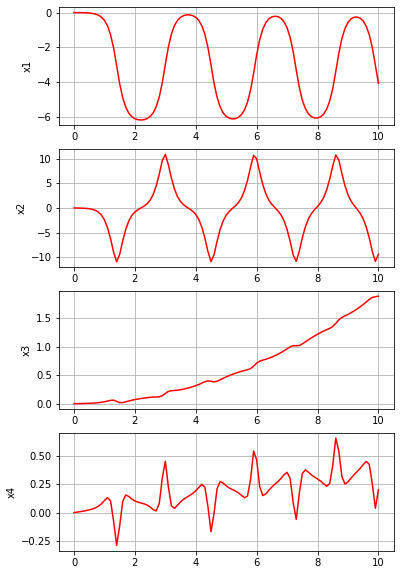

In [74]:
x_plot = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]
plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [75]:
x_list3 = []
x_list3.append(x_init.flatten().tolist())

In [76]:
uk = np.array([[0.1]])
xk = x_init

for i in range(N):
    if i == 0:
        x0 = np.array([[0],[0],[0],[0]])
        u0 = uk

    x_next = x_next_fn_lin(x0,xk,u0,uk)
    print(x_next)
    x_list3.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

[-0.000593104, -0.0121501, 0.000208787, 0.0041848]
[-0.00255245, -0.0280187, 0.000840815, 0.00848667]
[-0.00647745, -0.0524575, 0.00191495, 0.0130583]
[-0.0135685, -0.0929389, 0.003469, 0.018135]
[-0.0259941, -0.161838, 0.00557117, 0.0241056]
[-0.0475527, -0.280197, 0.00834089, 0.0316292]
[-0.084829, -0.484071, 0.0119844, 0.0418229]
[-0.149178, -0.835052, 0.0168534, 0.0565295]
[-0.260046, -1.4366, 0.0235305, 0.078509]
[-0.45015, -2.4533, 0.0328926, 0.110437]
[-0.771824, -4.10554, 0.045833, 0.14741]
[-1.29791, -6.54496, 0.0612749, 0.146832]
[-2.10132, -9.58933, 0.0696459, -0.0214966]
[-3.21757, -12.5515, 0.0480077, -0.42089]
[-4.45594, -10.9726, 0.00508534, -0.263458]
[-5.30573, -6.53107, 0.0106231, 0.262418]
[-5.85931, -4.72336, 0.0363577, 0.220992]
[-6.2832, -3.9751, 0.0565532, 0.187845]
[-6.69696, -4.51831, 0.0753462, 0.193237]
[-7.22854, -6.31456, 0.0955917, 0.205763]
[-7.99467, -9.1384, 0.113018, 0.10706]
[-9.07311, -12.4465, 0.106632, -0.28278]
[-10.4259, -13.5226, 0.0595347, -0.5

In [77]:
x_plot = np.array(x_list3)
tgrid = [delta_t * k for k in range(N + 1)]

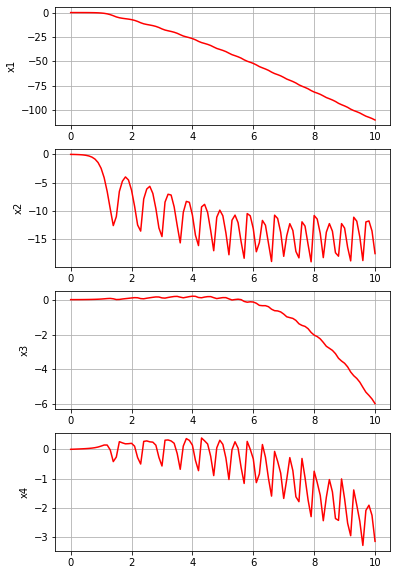

In [78]:
plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [79]:
x_list4 = []
x_list4.append(x_init.flatten().tolist())

In [80]:
xk = x_init
for i in range(N):    
    x_next_real = integrator_rk4(ode,xk,uk,delta_t)
    x_list4.append(x_next_real.full().flatten().tolist())
    xk = x_next_real
    

In [81]:
x_plot

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-5.93104473e-04, -1.21501045e-02,  2.08786710e-04,
         4.18480170e-03],
       [-2.55244773e-03, -2.80186877e-02,  8.40814686e-04,
         8.48667129e-03],
       [-6.47744599e-03, -5.24574742e-02,  1.91495484e-03,
         1.30583425e-02],
       [-1.35685331e-02, -9.29388981e-02,  3.46899569e-03,
         1.81349720e-02],
       [-2.59941236e-02, -1.61837755e-01,  5.57117324e-03,
         2.41055578e-02],
       [-4.75527242e-02, -2.80197471e-01,  8.34088513e-03,
         3.16292426e-02],
       [-8.48289789e-02, -4.84070564e-01,  1.19843758e-02,
         4.18228613e-02],
       [-1.49177940e-01, -8.35051841e-01,  1.68534499e-02,
         5.65295159e-02],
       [-2.60045757e-01, -1.43660294e+00,  2.35305027e-02,
         7.85089747e-02],
       [-4.50150300e-01, -2.45330360e+00,  3.28925624e-02,
         1.10436764e-01],
       [-7.71824335e-01, -4.10554283e+00,  4.58329724e-02,
      

In [82]:
x_plot = np.array(x_list4)
tgrid = [delta_t * k for k in range(N + 1)]
# x1_plot = x_plot[:,0]
# x2_plot = x_plot[:,1]
# x3_plot = x_plot[:,2]
# x4_plot = x_plot[:,3]

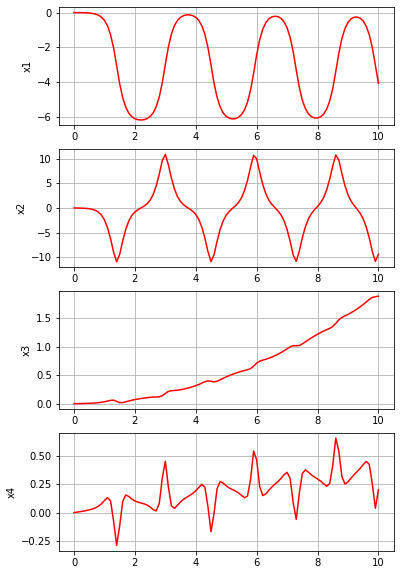

In [83]:
plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

### Test 2: Evolution within a short interval

#### $\Delta_{sample} = 0.1 s$, $\Delta_{interval} = 1s$

In [84]:
100 % 10

0

In [85]:
N

100

In [108]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.

for i in range(N):
    if i == 0:
        x0 = x_init
        u0 = uk

        
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


#### $\Delta_{sample} = 0.1 s$, $\Delta_{interval} = 1s$

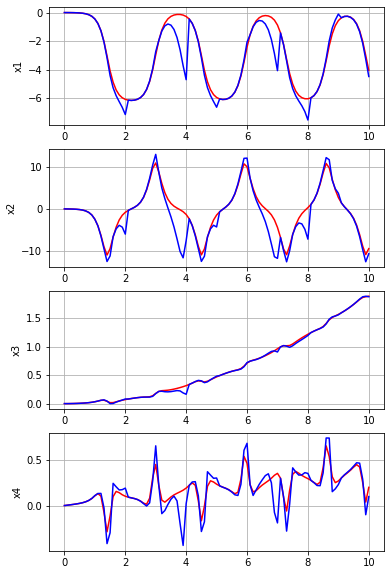

In [109]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

#### without updating $x_0$ within $\Delta_{interval}$

In [112]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.

for i in range(N):
#     if i == 0:
#         x0 = x_init
#         u0 = uk
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
        
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    

    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
#     x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


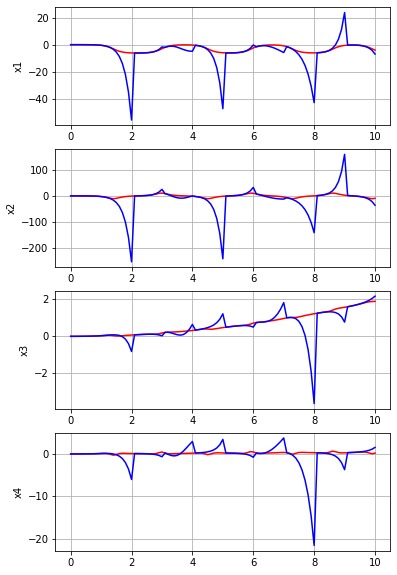

In [113]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

#### $\Delta_{sample} = 0.01 s$, $\Delta_{interval} = 1s$

In [96]:
x_SX = ca.SX.sym("x_SX", 4)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [inverted_pendulum_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.01

sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 4)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 4)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0) 
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

In [99]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 100 # give accurate state every 1 second.
N = 1000
for i in range(N):
    if i == 0:
        x0 = x_init
        u0 = uk

        
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

0
100
200
300
400
500
600
700
800
900


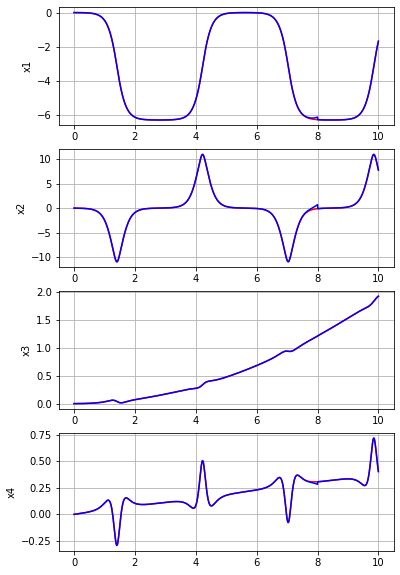

In [100]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

### Test 3: Time-varying input

#### $\Delta_{sample} = 0.1 s$, $\Delta_{interval} = 1s$

In [118]:
N = 100

In [123]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.
N = 100
for i in range(N):
    
    uk = np.sin(i * delta_t)
    if i == 0:
        x0 = x_init
        u0 = uk

    
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


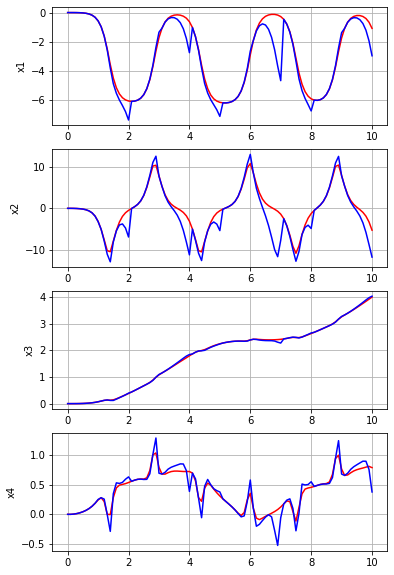

In [124]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

#### without updating $x_0$ within $\Delta_{interval}$

$\Delta_{interval} = 1s$

In [127]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.

for i in range(N):
#     if i == 0:
#         x0 = x_init
#         u0 = uk
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
        
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    

    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
#     x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


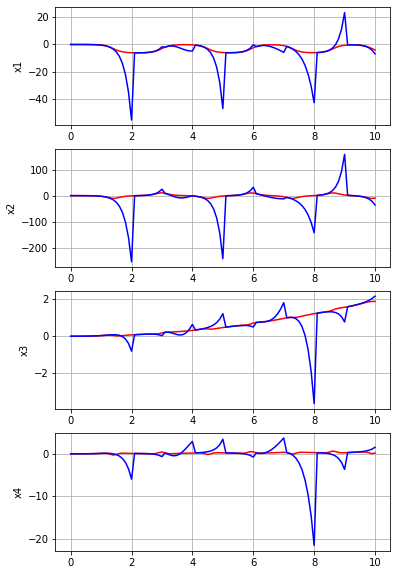

In [128]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

$\Delta_{interval} = 0.5s$

In [129]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 5 # give accurate state every 0.5 second.

for i in range(N):
#     if i == 0:
#         x0 = x_init
#         u0 = uk
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
        
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    

    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
#     x0 = xk_appr
    xk_appr = x_next_appr

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


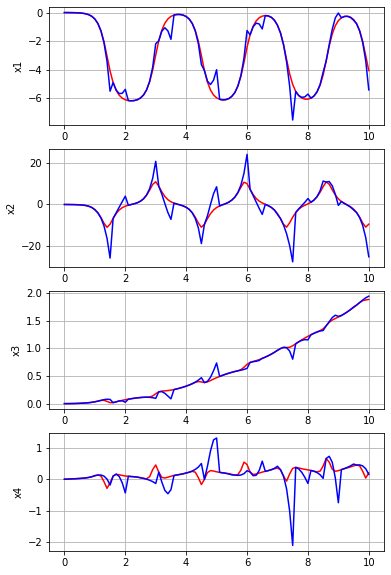

In [130]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

### Test 4: MPC

#### $\Delta_{sample} = 0.1 s$

In [1049]:
x_SX = ca.SX.sym("x_SX", 4)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [inverted_pendulum_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1

sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 4)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 4)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0) 
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

delta_fn = ca.Function("delta_fn", [x0,u0], [sys_int_fn(x0,u0) - A_fn(x0,u0) @  x0 - B_fn(x0,u0) @ u0] )

In [1050]:
sys_int_fn(x0,u0)

SX(@1=0.0166667, @2=2, @3=0.05, @4=25.8003, @5=0.0828, @6=0.9468, @7=((((u0_SX*cos(x0_SX_0))-(@4*sin(x0_SX_0)))+(((@5*cos(x0_SX_0))*sin(x0_SX_0))*sq(x0_SX_1)))/((@5*sq(cos(x0_SX_0)))-@6)), @8=(x0_SX_1+(@3*@7)), @9=(x0_SX_0+(@3*x0_SX_1)), @10=((((u0_SX*cos(@9))-(@4*sin(@9)))+(((@5*cos(@9))*sin(@9))*sq(@8)))/((@5*sq(cos(@9)))-@6)), @11=(x0_SX_1+(@3*@10)), @12=0.1, @13=(x0_SX_0+(@3*@8)), @14=((((u0_SX*cos(@13))-(@4*sin(@13)))+(((@5*cos(@13))*sin(@13))*sq(@11)))/((@5*sq(cos(@13)))-@6)), @15=(x0_SX_1+(@12*@14)), @16=(x0_SX_0+(@12*@11)), @17=2.2563, @18=2.63, @19=0.23, @20=(((u0_SX+((@5*sin(x0_SX_0))*sq(x0_SX_1)))-((@17*cos(x0_SX_0))*sin(x0_SX_0)))/(@18-(@19*sq(cos(x0_SX_0))))), @21=(((u0_SX+((@5*sin(@9))*sq(@8)))-((@17*cos(@9))*sin(@9)))/(@18-(@19*sq(cos(@9))))), @22=(((u0_SX+((@5*sin(@13))*sq(@11)))-((@17*cos(@13))*sin(@13)))/(@18-(@19*sq(cos(@13))))), [(x0_SX_0+(@1*(((x0_SX_1+(@2*@8))+(@2*@11))+@15))), (x0_SX_1+(@1*(((@7+(@2*@10))+(@2*@14))+((((u0_SX*cos(@16))-(@4*sin(@16)))+(((@5*cos(@16

In [1051]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]

N_pred = 20

xi_var = ca.SX.sym('x', 4, N_pred+1)
x0_para = ca.SX.sym('x0', 4, 1)
x_lin_para = ca.SX.sym('xlin', 4, 1)
# yr_para = ca.SX.sym('yr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)

# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 1000 * np.eye(4)
R = 1 * np.eye(1)
Qf = 10 * np.eye(4)

g = []

delta = delta_fn(x_lin_para,u_lin_para)
for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:,i-1] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,i-1] + delta)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para, x_lin_para, u_lin_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_appr = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



#### Simulation

In [1052]:
[xk, x_lin_para, u_lin_para]

[SX([xk_SX_0, xk_SX_1, xk_SX_2, xk_SX_3]),
 SX([xlin_0, xlin_1, xlin_2, xlin_3]),
 SX(ulin)]

In [1053]:
lbg =  [0] * 4 * (N_pred + 1)
ubg =  [0] * 4 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg


x0 = np.array([[np.pi],[0],[0],[0]])
u0 = np.array([[0]])

x_appr_list = []

xk = x0
uk = u0


x_appr_list.append( xk.flatten().tolist())

In [1054]:
u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [1055]:

# Simulation for 20 seconds
N_sim = 200
for i in range(N_sim):
    if i == 0:
        x_lin = x0
        u_lin = u0
    
    p = np.vstack([xk, x_lin, u_lin])
    nl['p'] = p
    
    sol = solver_appr(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next


#### Real system

In [1056]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]



N_pred = 20

xi_var = ca.SX.sym('x', 4, N_pred+1)
x0_para = ca.SX.sym('x0', 4, 1)
x_lin_para = ca.SX.sym('xlin', 4, 1)
# yr_para = ca.SX.sym('yr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)

# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 1000 * np.eye(4)
R = 1 * np.eye(1)
Qf = 10 * np.eye(4)

g = []


for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



In [1057]:
lbg =  [0] * 4 * (N_pred + 1)
ubg =  [0] * 4 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg


x0 = np.array([[np.pi],[0],[0],[0]])
u0 = np.array([[0]])

x_real_list = []

xk = x0
uk = u0


x_real_list.append(xk.flatten().tolist())

In [1058]:
u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [1059]:

# Simulation for 20 seconds
N_sim = 200
for i in range(N_sim):
    p = np.vstack([xk])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next


CasADi - 2021-08-16 10:47:17 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 9, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:17 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 9, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:17 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 5, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:18 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 5, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:18 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 5, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:18 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 9, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:18 WARNING("solver:nlp_g failed: Inf detected for output g, at (row 4, col 0).")

Sorry, things failed ?!?!


2021-08-16 10:47:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../cas

CasADi - 2021-08-16 10:47:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 10:47:20 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).")

In [1060]:
x_real_list

[[3.141592653589793, 0.0, 0.0, 0.0],
 [44.730380059853985,
  559.4943928625253,
  17.997338691786112,
  936.9279970927826],
 [54.43191574720512,
  -449.57465456547664,
  112.40634883145432,
  670.2640430164099],
 [-57.69476289382073,
  -1559.0001376843393,
  -13.346408276045196,
  -2908.3304038100296],
 [-2615.8537391006153,
  -5201626.139106144,
  -1319.3408556279699,
  -16841794.606140934],
 [7.16338142860874e+32,
  -8.038690151743654e+65,
  -5.7738230600260345e+32,
  -9.289580321835041e+65],
 [-inf, nan, -inf, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan, nan],
 [nan, nan, nan

In [1061]:
x_plot_appr

array([[4.32940000e+02, 1.29800000e-01],
       [4.40185590e+02, 8.75875658e-02],
       [4.39498055e+02, 8.79836484e-02],
       [4.37431142e+02, 9.63172730e-02],
       [4.35602478e+02, 1.04666927e-01],
       [4.33944825e+02, 1.13147838e-01],
       [4.32471490e+02, 1.21506187e-01],
       [4.31183003e+02, 1.29566714e-01],
       [4.30079289e+02, 1.37173611e-01],
       [4.29161434e+02, 1.44179935e-01],
       [4.28433013e+02, 1.50438586e-01],
       [4.27900896e+02, 1.55795570e-01],
       [4.27575754e+02, 1.60084706e-01],
       [4.27472236e+02, 1.63124007e-01],
       [4.27608625e+02, 1.64715035e-01],
       [4.28005446e+02, 1.64648070e-01],
       [4.28682131e+02, 1.62718412e-01],
       [4.29650214e+02, 1.58762639e-01],
       [4.30901058e+02, 1.52726880e-01],
       [4.32386829e+02, 1.44776480e-01],
       [4.33997861e+02, 1.35433488e-01],
       [4.35551008e+02, 1.25666815e-01],
       [4.36816692e+02, 1.16782881e-01],
       [4.37599909e+02, 1.10015139e-01],
       [4.378298

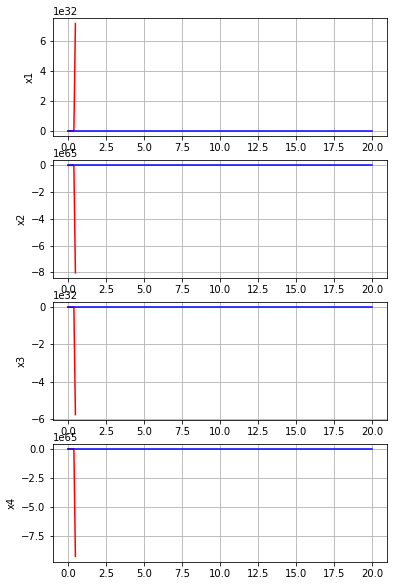

In [319]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

In [277]:
x_plot_appr

array([[ 2.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.11830333e+00,  2.34160936e+00, -3.64526717e-03,
        -6.95845060e-02],
       [ 2.44288878e+00,  4.03473011e+00, -2.17263140e-02,
        -2.89306042e-01],
       [ 2.87023706e+00,  4.28684216e+00, -7.09603799e-02,
        -7.04128133e-01],
       [ 3.26841636e+00,  3.47149561e+00, -1.58880192e-01,
        -1.06401065e+00],
       [ 3.55401596e+00,  2.11835386e+00, -2.76402563e-01,
        -1.28974967e+00],
       [ 3.69518536e+00,  6.52020753e-01, -4.08908345e-01,
        -1.36055332e+00],
       [ 3.69656052e+00, -6.23931829e-01, -5.41082489e-01,
        -1.28289972e+00],
       [ 3.58936561e+00, -1.47082467e+00, -6.59548361e-01,
        -1.08565396e+00],
       [ 3.42354349e+00, -1.76337373e+00, -7.55020101e-01,
        -8.21416882e-01],
       [ 3.25314309e+00, -1.55866584e+00, -8.23867316e-01,
        -5.52542212e-01],
       [ 3.11966226e+00, -1.04563482e+00, -8.67994590e-01,
      

### New linearization approach: linearize at the current state

In [1062]:
x_SX = ca.SX.sym("x_SX", 4)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [inverted_pendulum_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1
# N = 5

In [1063]:
sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])
A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 4)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 4)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0)
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

In [1064]:
N = 100

x_init = np.array([[0],[0],[0],[0]])


x_next = A_fn(x0,u0) @ xk +  B_fn(x0,u0) @ uk
x_next_fn = ca.Function("x_next_fn",[x0,xk,u0,uk],[x_next])

x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk = x_init

for i in range(N):
    if i == 0:
        u0 = uk

    x_next = x_next_fn_lin(xk,xk,u0,uk)
#     x_next = x_next_fn_lin(x0,xk,u0,uk)
#     print(x_next)
    x_list1.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

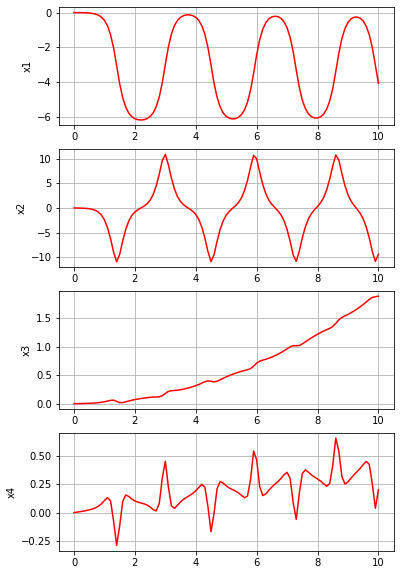

In [1065]:
    
x_plot = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

#### $\Delta_{sample} = 0.1 s$, $\Delta_{interval} = 1s$

In [1066]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[0.1]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.
N = 100
for i in range(N):
    
    uk = np.sin(i * delta_t)
    if i == 0:
        x0 = x_init
        u0 = uk

    
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


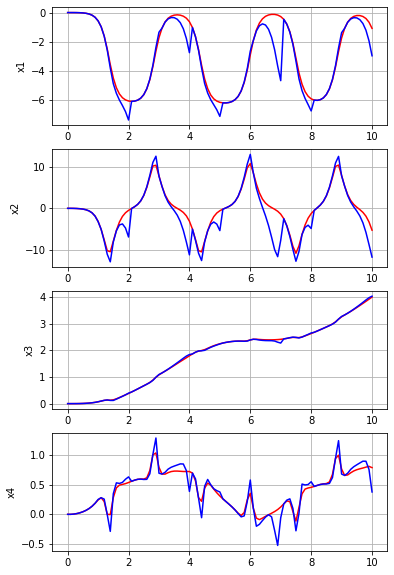

In [1067]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

### Test: MPC

#### $\Delta_{sample} = 0.1 s$

In [1068]:
terminal_state = ca.DM([[0],[0],[0],[0]])

In [1069]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]

N_pred = 5

xi_var = ca.SX.sym('x', 4, N_pred+1)
# xi_var = ca.SX.sym('x', 4, N_pred)
x0_para = ca.SX.sym('x0', 4, 1)
x_lin_para = ca.SX.sym('xlin', 4, 1)
# yr_para = ca.SX.sym('yr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)

# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 100 * np.eye(4)
R = 1 * np.eye(1)
Qf = 10 * np.eye(4)

g = []

delta = delta_fn(x_lin_para,u_lin_para)
for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:,i-1] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,i-1] + delta)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        
# g += [terminal_state - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        

# g += [xi_var[:, -1] - terminal_state]
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para, x_lin_para, u_lin_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_appr = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



Approximated system

In [1070]:
N_sim = 200

In [1071]:
lbg =  [0] * 4 * (N_pred + 1)
ubg =  [0] * 4 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2
x1_start = np.pi

x0 = np.array([[x1_start],[0],[0],[0]])
u0 = np.array([[0]])

x_appr_list = []

xk = x0
uk = u0

# nl['x0'] = [0, 0, 0, 0] * (N_pred+1) + [0] * N_pred

x_appr_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]


# Simulation for 20 seconds

for i in range(N_sim):
    x_lin = xk
    u_lin = uk
    
    p = np.vstack([xk, x_lin, u_lin])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    xk = x_next

input [[-4.47457519]
 [-1.43590462]
 [-0.88878508]
 [-0.8187194 ]
 [-0.40018719]]
input [[-1.87032373]
 [-1.66052597]
 [-1.87278895]
 [-1.65943695]
 [-0.53744066]]
input [[-1.77531149]
 [-2.56318373]
 [-2.79280181]
 [-2.23161024]
 [-0.60034058]]
input [[-2.39878528]
 [-3.44062309]
 [-3.42081201]
 [-2.50217342]
 [-0.59686237]]
input [[-3.04507019]
 [-4.02285784]
 [-3.67795899]
 [-2.47324621]
 [-0.53689342]]
input [[-3.46520893]
 [-4.23185623]
 [-3.57114244]
 [-2.18519111]
 [-0.43495207]]
input [[-3.59030651]
 [-4.08548152]
 [-3.1626203 ]
 [-1.70655873]
 [-0.30765254]]
input [[-3.4279954 ]
 [-3.65031192]
 [-2.5417443 ]
 [-1.11498646]
 [-0.17030991]]
input [[-3.02464208]
 [-3.01325636]
 [-1.80127509]
 [-0.48124905]
 [-0.03514233]]
input [[-2.44733539]
 [-2.26272259]
 [-1.02244392]
 [ 0.13871719]
 [ 0.08901973]]
input [[-1.77029137]
 [-1.47716186]
 [-0.26898861]
 [ 0.70482106]
 [ 0.19623495]]
input [[-1.06351418]
 [-0.71972105]
 [ 0.41283531]
 [ 1.19035659]
 [ 0.28281937]]
input [[-0.38513

input [[ 0.0761131 ]
 [-0.54079432]
 [-0.20530506]
 [ 0.10971491]
 [-0.02265616]]
input [[ 0.07435646]
 [-0.54405605]
 [-0.20900899]
 [ 0.10619551]
 [-0.02337872]]
input [[ 0.07264949]
 [-0.54723387]
 [-0.2126207 ]
 [ 0.10276137]
 [-0.02408405]]
input [[ 0.07098948]
 [-0.55033172]
 [-0.21614444]
 [ 0.09940881]
 [-0.0247729 ]]
input [[ 0.06937355]
 [-0.55335357]
 [-0.21958428]
 [ 0.09613438]
 [-0.02544595]]
input [[ 0.06779882]
 [-0.55630321]
 [-0.22294405]
 [ 0.09293492]
 [-0.02610381]]
input [[ 0.06626255]
 [-0.55918418]
 [-0.2262272 ]
 [ 0.0898076 ]
 [-0.02674702]]
input [[ 0.06476224]
 [-0.56199962]
 [-0.22943675]
 [ 0.08674995]
 [-0.02737603]]
input [[ 0.06329573]
 [-0.5647523 ]
 [-0.23257532]
 [ 0.08375985]
 [-0.02799123]]
input [[ 0.06186117]
 [-0.56744454]
 [-0.23564512]
 [ 0.0808355 ]
 [-0.02859294]]
input [[ 0.06045709]
 [-0.57007826]
 [-0.23864795]
 [ 0.07797539]
 [-0.02918143]]
input [[ 0.05908237]
 [-0.57265502]
 [-0.24158533]
 [ 0.0751782 ]
 [-0.02975695]]
input [[ 0.05773

Real system

In [1072]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]



N_pred = 10

# xi_var = ca.SX.sym('x', 4, N_pred+1)
xi_var = ca.SX.sym('x', 4, N_pred)
x0_para = ca.SX.sym('x0', 4, 1)
x_lin_para = ca.SX.sym('xlin', 4, 1)
# yr_para = ca.SX.sym('yr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)

# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 10 * np.eye(4)
R = 1 * np.eye(1)
Qf = 10 * np.eye(4)

g = []


for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



lbg =  [0] * 4 * (N_pred + 1)
ubg =  [0] * 4 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

In [1073]:
x0 = np.array([[x1_start],[0],[0],[0]])
u0 = np.array([[0]])

x_real_list = []

xk = x0
uk = u0


x_real_list.append(xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [1074]:
# Simulation for 20 seconds
for i in range(N_sim):
    p = np.vstack([xk])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next

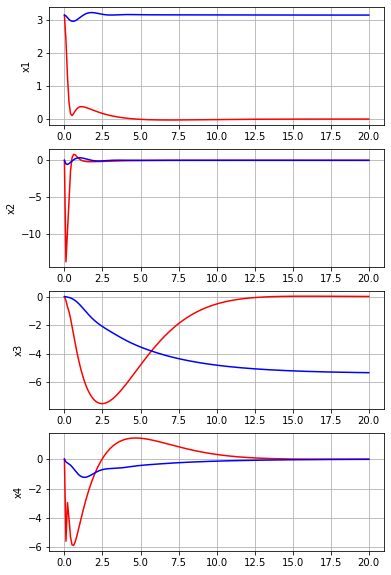

In [1075]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (4):
    plt.subplot( str(4) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

### CSTR example

Reference: https://reader.elsevier.com/reader/sd/pii/S1474667017313228?token=224BC5B42F541F7B66DCFCA4C355C5DAF8A9484522CE62C7723030A67751FA3B18D80FE8CF0D7ED3551E17EA1BA2D908&originRegion=eu-west-1&originCreation=20210815142702

$$
\begin{array}{ll}
q_{f} & 100 \\
C_{f} & 1 \\
T_{f} & 350 \\
T_{c} & 350 \\
E / R & 10000 \\
V & 100 \\
K_{0} & 7.2 \cdot 10^{10} \\
K_{1} & 1.44 \cdot 10^{13} \\
K_{2} & 0.01 \\
K_{3} & 700
\end{array}
$$

Mass balance:
$$
\frac{d T}{d t}= \frac{q_{f}}{V}\left(T_{f}-T\right)+K_{1} C e^{-\frac{E}{RT}} +K_{2} q_{c}\left(1-e^{-\frac{K_{3}}{q_c}}\right)\left(T_{c}-T\right)
$$
Energy balance:
$$
\frac{d C}{d t}=\frac{q_{f}}{V}\left(C_{f}-C\right)-K_{0} C e^{-\frac{E}{R T}}
$$

In [746]:
def CSTR_nonlinear_ode(x, u):
    qf = 100
    Cf = 1
    Tf = 350
    Tc = 350
    E_R = 10000
    V = 100
    K0 = 7.2e10
    K1 = 1.44e13
    K2 = 0.01
    K3 = 700
    
    
    dx1_dt = qf/V * (Tf - x[0]) + K1 * x[1] * ca.exp(-E_R/x[0]) + K2 * u[0] * (1 - ca.exp(-K3/u[0])) * (Tc - x[0])
    dx2_dt = qf/V * (Cf - x[1]) - K0 * x[1] * ca.exp(-E_R/x[0])
    rhs = [dx1_dt,
           dx2_dt
           ]
    
    return ca.vertcat(*rhs)

In [803]:
x_SX = ca.SX.sym("x_SX", 2)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [CSTR_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1
# N = 5

In [804]:
sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])
A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 2)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 2)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0)
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

In [805]:
N = 100

x_init = np.array([[432.94],[0.1298]])


x_next = A_fn(x0,u0) @ xk +  B_fn(x0,u0) @ uk
x_next_fn = ca.Function("x_next_fn",[x0,xk,u0,uk],[x_next])

In [806]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk = x_init

for i in range(N):
    if i == 0:
        u0 = uk

    x_next = x_next_fn_lin(xk,xk,u0,uk)
#     x_next = x_next_fn_lin(x0,xk,u0,uk)
#     print(x_next)
    x_list1.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

#### Openloop simulation

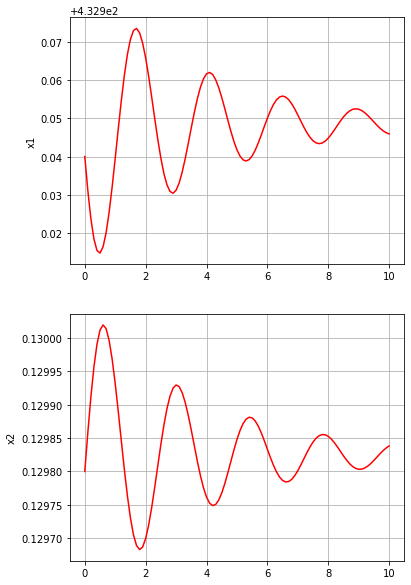

In [807]:
x_plot = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [808]:
x_list1

[[432.94, 0.1298],
 [432.9310417291843, 0.12985827088940946],
 [432.92370541824255, 0.12991141968390385],
 [432.9183950035061, 0.12995618132916417],
 [432.9153606705444, 0.12999000720774584],
 [432.9146902165155, 0.1300111964037518],
 [432.91631116806894, 0.1300189664520756],
 [432.9200030712434, 0.13001346164153746],
 [432.9254188128777, 0.1299957006417375],
 [432.9321133242112, 0.12996746887553343],
 [432.93957758400273, 0.1299311644754704],
 [432.94727551682263, 0.12988960960005155],
 [432.9546812105759, 0.12984584107620445],
 [432.96131388735694, 0.12980289553227506],
 [432.9667682689094, 0.12976360422200509],
 [432.9707383749859, 0.12973041156531281],
 [432.9730333475086, 0.12970522914078902],
 [432.9735845517313, 0.12968933368956784],
 [432.97244390019085, 0.12968331396583072],
 [432.96977400619227, 0.1296870673799861],
 [432.9658313395149, 0.12969984369959395],
 [432.9609439836375, 0.12972032990964102],
 [432.9554858581061, 0.1297467678994514],
 [432.9498493698571, 0.12977709504

In [809]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.
N = 100
for i in range(N):
    
#     uk = np.sin(i * delta_t)
    if i == 0:
        x0 = x_init
        u0 = uk

    
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
    if i % N_delta == 0:
        print(i)
        xk_appr = xk_real
        x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

0
10
20
30
40
50
60
70
80
90


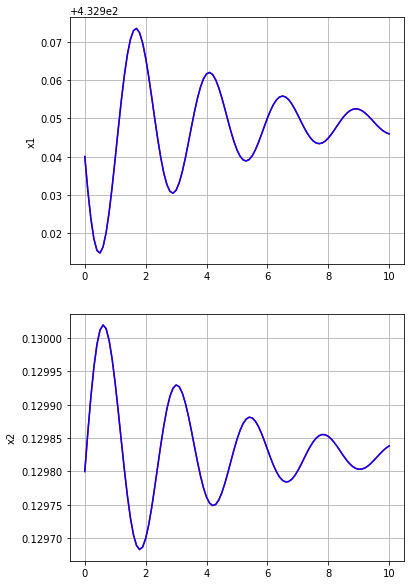

In [810]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

#### step response

In [811]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk = x_init

step_input_list = [110,105,98.9,88.3,68.8]
N_len = len(step_input_list)

N = 50
input_counter = 0
for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1
    uk = step_input_list[input_counter]
    u0 = uk
    x_next = x_next_fn_lin(xk,xk,u0,uk)
#     x_next = x_next_fn_lin(x0,xk,u0,uk)
#     print(x_next)
    x_list1.append(x_next.full().flatten().tolist())
    x0 = xk
    xk = x_next

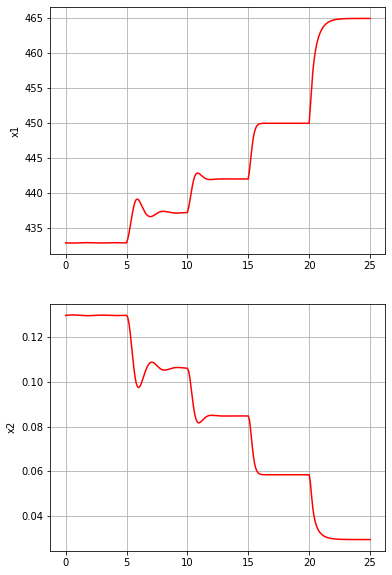

In [812]:
x_plot = np.array(x_list1)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt = x_plot[:,i]
    plt.plot(tgrid, x_opt, 'r')
    plt.ylabel('x' + str(i + 1))

In [815]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

x_list2 = []
x_list2.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk_real = x_init
xk_appr = x_init

N_delta = 10 # give accurate state every 1 second.
N = 50

step_input_list = [110,105,98.9,88.3,68.8]
N_len = len(step_input_list)
input_counter = 0
for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1
    uk = step_input_list[input_counter]
    u0 = uk

    
    x_next_real = integrator_rk4(ode,xk_real,uk,delta_t)
    x_list1.append(x_next_real.full().flatten().tolist())

    
#     if i % N_delta == 0:
#         print(i)
#         xk_appr = xk_real
#         x0 = xk_appr
    
    x_next_appr = x_next_fn_lin(x0,xk_appr,u0,uk)
#     print(x_next)
    x_list2.append(x_next_appr.full().flatten().tolist())

    
    
    xk_real = x_next_real
    
    x0 = xk_appr
    xk_appr = x_next_appr

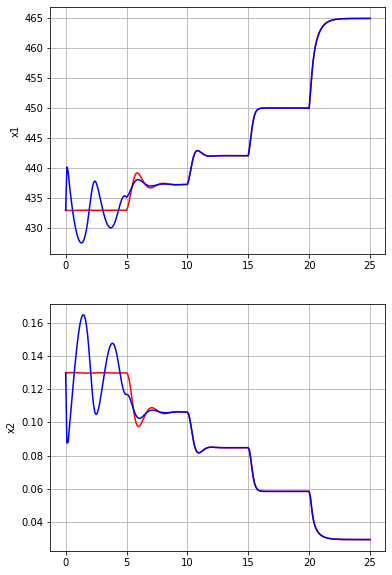

In [816]:
x_plot_real = np.array(x_list1)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_appr = np.array(x_list2)
tgrid = [delta_t * k for k in range(N * N_len+ 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

### Test: MPC

In [1080]:
x_SX = ca.SX.sym("x_SX", 2)
u_SX = ca.SX.sym("u_SX", 1)

ode = ca.Function("ode_func", [x_SX, u_SX], [CSTR_nonlinear_ode(x_SX, u_SX)])
delta_t = 0.1

sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

A = ca.jacobian(sys_int,x_SX)
B = ca.jacobian(sys_int,u_SX)

A_fn = ca.Function("A_fn",[x_SX,u_SX],[A])
B_fn = ca.Function("B_fn",[x_SX,u_SX],[B])

x0 =  ca.SX.sym("x0_SX", 2)
u0 = ca.SX.sym("u0_SX", 1)

xk =  ca.SX.sym("xk_SX", 2)
uk = ca.SX.sym("uk_SX", 1)


x_next = sys_int_fn(x0,u0) + A_fn(x0,u0) @(xk - x0) + B_fn(x0,u0) @ (uk - u0) 
x_next_fn_lin = ca.Function("x_next_fn_lin", [x0,xk,u0,uk],[x_next])

delta_fn = ca.Function("delta_fn", [x0,u0], [sys_int_fn(x0,u0) - A_fn(x0,u0) @  x0 - B_fn(x0,u0) @ u0] )

In [1092]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]

N_pred = 10

xi_var = ca.SX.sym('x', 2, N_pred+1)
# xi_var = ca.SX.sym('x', 4, N_pred)
x0_para = ca.SX.sym('x0', 2, 1)
x_lin_para = ca.SX.sym('xlin', 2, 1)
xr_para = ca.SX.sym('xr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
u_lin_para = ca.SX.sym('ulin', 1, 1)
ur_para = ca.SX.sym('ur', 1, 1)
# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 10 * np.eye(2)
R = 1 * np.eye(1)
Qf = 10 * np.eye(2)

g = []

delta = delta_fn(x_lin_para,u_lin_para)
for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  (xi_var[:,i] - xr_para).T @ Q @  (xi_var[:,i] - xr_para) + (ui_var[:,i] - ur_para).T @ R @ (ui_var[:,i] - ur_para)
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:,i-1] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,i-1] + delta)]

obj += (xi_var[:, -1]- xr_para).T @ Qf @ (xi_var[:, -1]- xr_para)
g += [xi_var[:, -1] - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        
# g += [terminal_state - (A_fn(x_lin_para,u_lin_para) @ xi_var[:, -2] + B_fn(x_lin_para,u_lin_para) @ ui_var[:,  -1] + delta)] # Terminal state        

# g += [xi_var[:, -1] - terminal_state]
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para, x_lin_para, u_lin_para, xr_para,ur_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_appr = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



In [1016]:
N_sim = 200

In [1017]:
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2
x1_start = 432.94
x2_start = 0.1298

x1r = 437.25
x2r = 0.1062

x0 = np.array([[x1_start],[x2_start]])
u0 = np.array([[110]])

xr = np.array([[x1r],[x2r]])
ur = np.array([[105]])
x_appr_list = []

xk = x0
uk = u0


x_appr_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]


# Simulation for 20 seconds

for i in range(N_sim):
    x_lin = xk
    u_lin = uk
    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    xk = x_next

input [[ 98.91112958]
 [104.29705523]
 [107.43209384]
 [108.82636615]
 [109.0308685 ]
 [108.53327581]
 [107.71097186]
 [106.82352955]
 [106.02863895]
 [105.40883325]]
input [[104.26369532]
 [107.46193253]
 [108.81123091]
 [108.94774007]
 [108.41432884]
 [107.61088167]
 [106.7926999 ]
 [106.09504668]
 [105.56782892]
 [105.21025212]]
input [[106.95847489]
 [108.2670777 ]
 [108.38324598]
 [107.85441685]
 [107.08568784]
 [106.33424908]
 [105.73300987]
 [105.32502628]
 [105.09709976]
 [105.00663264]]
input [[107.90480868]
 [108.04007799]
 [107.53575195]
 [106.79792181]
 [106.08246716]
 [105.51952786]
 [105.14960629]
 [104.95846439]
 [104.90433968]
 [104.93561597]]
input [[107.8545165 ]
 [107.3885662 ]
 [106.68409689]
 [105.99648027]
 [105.45388825]
 [105.09493734]
 [104.90505448]
 [104.84480904]
 [104.86827985]
 [104.93244208]]
input [[107.32378638]
 [106.64824942]
 [105.98212089]
 [105.45319083]
 [105.09948016]
 [104.90628461]
 [104.83512484]
 [104.84272865]
 [104.8910522 ]
 [104.95065115]

input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]]
input [[105.00589061]
 [105.00607278]
 [105.00623113]
 [105.00633708]
 [105.00633642]
 [105.0061465 ]
 [105.00566411]
 [105.00478964]
 [105.00347266]
 [105.00178242]

Real system

In [1093]:
obj = 0

# state_prev_temp = np.zeros(np.shape(state_temp))
# A = (state_temp @ state_temp.T) * Theta_1  + (state_prev_temp @ state_prev_temp.T) * Theta_2 + Theta_3 * np.eye(np.shape(state_temp)[0])
# B = (state_temp @ Theta_4)

# nx = np.shape(A)[0]
# ny = 2
# nu = np.shape(B)[1]



N_pred = 10

# xi_var = ca.SX.sym('x', 4, N_pred+1)
xi_var = ca.SX.sym('x', 2, N_pred+1)
x0_para = ca.SX.sym('x0', 2, 1)
xr_para = ca.SX.sym('xr', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)
ur_para = ca.SX.sym('ur', 1, 1)



# A_para = ca.SX.sym('A_para', nx, nx)
# B_para = ca.SX.sym('B_para', nx, nu)

Q = 10 * np.eye(2)
R = 1 * np.eye(1)
Qf = 10 * np.eye(2)

g = []


for i in range(N_pred):
#     obj += (C @ xi_var[:,i] - yr_para).T @ Q @ (C @ xi_var[:,i] - yr_para) + (ui_var[:,i]).T @ R @ (ui_var[:,i])
    obj +=  (xi_var[:,i] - xr_para).T @ Q @  (xi_var[:,i] - xr_para) + (ui_var[:,i] - ur_para).T @ R @ (ui_var[:,i] - ur_para)
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += (xi_var[:, -1]- xr_para).T @ Qf @ (xi_var[:, -1]- xr_para)
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para,xr_para,ur_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)

In [1019]:
xi_var.shape

(2, 11)

In [1020]:
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2
x1_start = 432.94
x2_start = 0.1298

x1r = 437.25
x2r = 0.1062
u1r = 105
x0 = np.array([[x1_start],[x2_start]])

xr = np.array([[x1r],[x2r]])
ur = np.array([[u1r]])
x_real_list = []

xk = x0
uk = u0
x_real_list = []
x_real_list.append(xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [1021]:
p = np.vstack([xk,xr,ur])
nl['p'] = p
x_guess = [x1r,x2r] * (N_pred+1) + [u1r] * N_pred
nl['x0'] = x_guess
sol = solver_real(**nl)

In [1022]:
# Simulation for 20 seconds
for i in range(N_sim):
    p = np.vstack([xk,xr,ur])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next

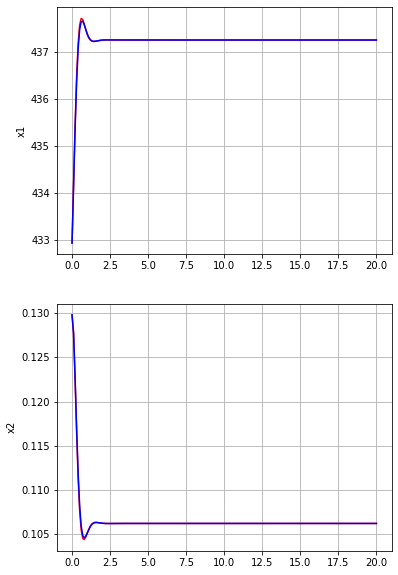

In [1023]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_appr, 'b')
    plt.ylabel('x' + str(i + 1))

In [1024]:
x_appr_list

[[432.94, 0.1298],
 [434.1643867269198, 0.1277554678795236],
 [435.3563413317841, 0.12275835106233204],
 [436.3510560731424, 0.11701232752737155],
 [437.05892624055446, 0.11194981289236305],
 [437.471148893786, 0.10824401839890394],
 [437.64144696954116, 0.1059769326712452],
 [437.6508862777655, 0.10489068431759031],
 [437.57642039852567, 0.10461166238462816],
 [437.474745276943, 0.10479067123588974],
 [437.3797049014437, 0.10516352635322185],
 [437.30671800890894, 0.10556083781548997],
 [437.2590582715396, 0.10589318124530622],
 [437.23339956162, 0.10612821699618023],
 [437.2238037393169, 0.1062684596424932],
 [437.2241758109994, 0.10633352575568494],
 [437.22951273996654, 0.10634791212925354],
 [437.23632401027595, 0.10633385818527875],
 [437.24255725461745, 0.10630815031620548],
 [437.2472857107153, 0.10628155130410022],
 [437.25033283509015, 0.10625967963426651],
 [437.25193647225865, 0.10624445631905124],
 [437.2524979755222, 0.10623555798219614],
 [437.2524232532511, 0.1062315894

Test: linearization around the set point

In [1025]:
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2
x1_start = 432.94
x2_start = 0.1298

x1r = 437.25
x2r = 0.1062

x0 = np.array([[x1_start],[x2_start]])
u0 = np.array([[110]])

xr = np.array([[x1r],[x2r]])
ur = np.array([[105]])
x_linear_list = []

xk = x0
uk = u0


x_linear_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]


x_lin = xr
u_lin = ur

x_guess = [x1r,x2r] * (N_pred + 1) + [u1r] * N_pred
nl['x0'] = x_guess
for i in range(N_sim):

    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_linear_list.append(x_next.full().flatten().tolist())
    
    xk = x_next

input [[100.1107006 ]
 [104.55071917]
 [106.87908679]
 [107.68739203]
 [107.57129666]
 [107.01325384]
 [106.3453284 ]
 [105.75946925]
 [105.3393502 ]
 [105.09635387]]
input [[103.99962906]
 [106.75492454]
 [107.80282231]
 [107.78503894]
 [107.23486214]
 [106.52776216]
 [105.88694571]
 [105.41516221]
 [105.13299527]
 [105.01229107]]
input [[106.42253958]
 [107.74857412]
 [107.88143215]
 [107.38689005]
 [106.67471315]
 [105.99677483]
 [105.47651703]
 [105.14805791]
 [104.99196876]
 [104.96175788]]
input [[107.60821819]
 [107.8690874 ]
 [107.44118012]
 [106.74986074]
 [106.06288378]
 [105.5167793 ]
 [105.1553938 ]
 [104.96668037]
 [104.91095018]
 [104.93880181]]
input [[107.83837052]
 [107.44512644]
 [106.7701775 ]
 [106.08534315]
 [105.5310478 ]
 [105.15433059]
 [104.94594623]
 [104.86949994]
 [104.88053896]
 [104.93651435]]
input [[107.45101223]
 [106.7756076 ]
 [106.08920143]
 [105.53159258]
 [105.14907091]
 [104.93183791]
 [104.84362964]
 [104.84145944]
 [104.88632253]
 [104.94706868]

input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]

input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]]
input [[105.00588902]
 [105.00607023]
 [105.00622837]
 [105.00633453]
 [105.00633423]
 [105.00614468]
 [105.00566265]
 [105.00478853]
 [105.00347194]
 [105.00178211]

#### Remark:

Simulation result depends on the initial guess.

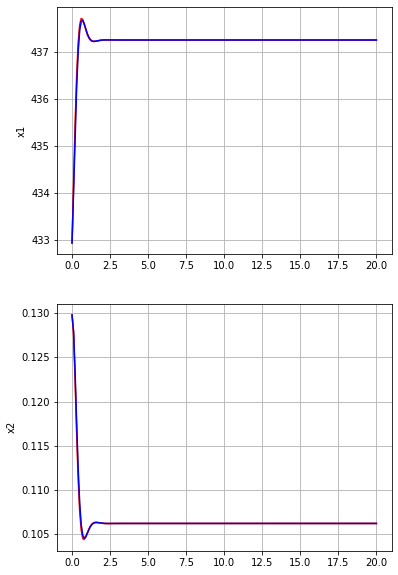

In [1045]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

x_plot_linear = np.array(x_linear_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_linear = x_plot_linear[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_appr, 'orange')
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_linear, 'b')
    plt.ylabel('x' + str(i + 1))

#### Test: Tracking MPC

In [1101]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk = x_init

ur_list = [110, 105, 98.9, 88.3, 68.6]
x1r_list = [432.94, 437.25, 442.07, 450.03, 465.00]
x2r_list = [0.1298, 0.1062, 0.0848, 0.0585, 0.0295]

x1_start = 420
x2_start = 0.1
u0 = np.array([[105]])


N = 50
N_len = len(step_input_list)


# for i in range(N * N_len):
#     if i % N == 0 and i != 0:
#         input_counter += 1
#     uk = step_input_list[input_counter]
#     u0 = uk
#     x_next = x_next_fn_lin(xk,xk,u0,uk)
# #     x_next = x_next_fn_lin(x0,xk,u0,uk)
# #     print(x_next)
#     x_list1.append(x_next.full().flatten().tolist())
#     x0 = xk
#     xk = x_next



### Appr
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2




x0 = np.array([[x1_start],[x2_start]])



x_appr_list = []

xk = x0
uk = u0


x_appr_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]



input_counter = 0



for i in range(N * N_len):
    x_lin = xk
    u_lin = uk

    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])   
    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    xk = x_next


### Real
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

x0 = np.array([[x1_start],[x2_start]])

xk = x0
uk = u0
x_real_list = []
x_real_list.append(xk.flatten().tolist())

input_counter = 0

for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])  
    
    
    p = np.vstack([xk,xr,ur])
    nl['p'] = p
    
    x_guess = [x1r_list[input_counter],x2r_list[input_counter]] * (N_pred+1) + [ur_list[input_counter]] * N_pred
    nl['x0'] = x_guess

    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next
### Linear
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2

x0 = np.array([[x1_start],[x2_start]])

xk = x0
uk = u0


x_linear_list = []
x_linear_list.append( xk.flatten().tolist())

input_counter = 0

for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])   
    x_lin = xr
    u_lin = ur    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p

    x_guess = [x1r_list[input_counter],x2r_list[input_counter]] * (N_pred + 1) + [ur_list[input_counter]] * N_pred
    nl['x0'] = x_guess
    
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]

    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_linear_list.append(x_next.full().flatten().tolist())
    
    xk = x_next





input [[ 32.88670101]
 [ 42.31380642]
 [ 52.5432103 ]
 [ 62.6974961 ]
 [ 72.23252905]
 [ 80.86113488]
 [ 88.48199766]
 [ 95.1157168 ]
 [100.84860996]
 [105.7839677 ]]
input [[ 32.41034771]
 [ 58.22407386]
 [ 78.2189158 ]
 [ 93.07733047]
 [103.5442573 ]
 [110.34713676]
 [114.15105054]
 [115.54045977]
 [115.02103732]
 [113.03689167]]
input [[ 56.82284484]
 [ 83.96172141]
 [102.10053416]
 [113.52325782]
 [120.01165161]
 [122.91353253]
 [123.21875213]
 [121.63605807]
 [118.66816593]
 [114.68534677]]
input [[ 81.77778964]
 [102.97065038]
 [115.76636017]
 [122.70481804]
 [125.64686801]
 [125.9121553 ]
 [124.40455936]
 [121.72258078]
 [118.25597519]
 [114.27246168]]
input [[100.52419266]
 [115.00519492]
 [122.82316991]
 [126.16965702]
 [126.63128006]
 [125.30941837]
 [122.93456985]
 [119.96957168]
 [116.70084365]
 [113.31999103]]
input [[112.37751051]
 [121.31062383]
 [125.29422183]
 [126.08842388]
 [124.97064649]
 [122.81710208]
 [120.19233877]
 [117.435932  ]
 [114.74152695]
 [112.22739848]

input [[105.00588699]
 [105.00607002]
 [105.00622933]
 [105.00633613]
 [105.00633608]
 [105.00614652]
 [105.0056643 ]
 [105.00478986]
 [105.00347283]
 [105.00178251]]
input [[105.00588784]
 [105.00607098]
 [105.00623017]
 [105.00633673]
 [105.00633645]
 [105.0061467 ]
 [105.00566436]
 [105.00478985]
 [105.0034728 ]
 [105.00178248]]
input [[105.00588881]
 [105.00607182]
 [105.00623078]
 [105.00633711]
 [105.00633664]
 [105.00614676]
 [105.00566434]
 [105.0047898 ]
 [105.00347276]
 [105.00178246]]
input [[105.00588965]
 [105.00607243]
 [105.00623115]
 [105.00633729]
 [105.00633669]
 [105.00614673]
 [105.00566429]
 [105.00478975]
 [105.00347272]
 [105.00178244]]
input [[105.00589026]
 [105.00607281]
 [105.00623134]
 [105.00633735]
 [105.00633666]
 [105.00614668]
 [105.00566423]
 [105.0047897 ]
 [105.00347269]
 [105.00178243]]
input [[105.00589064]
 [105.00607299]
 [105.00623139]
 [105.00633732]
 [105.0063366 ]
 [105.00614661]
 [105.00566417]
 [105.00478966]
 [105.00347267]
 [105.00178242]

input [[88.28601324]
 [88.28598748]
 [88.28596207]
 [88.28595467]
 [88.2860159 ]
 [88.28625959]
 [88.28690313]
 [88.28829935]
 [88.29089996]
 [88.2950049 ]]
input [[88.28601324]
 [88.28598748]
 [88.28596207]
 [88.28595467]
 [88.2860159 ]
 [88.28625959]
 [88.28690313]
 [88.28829935]
 [88.29089996]
 [88.2950049 ]]
input [[88.28601324]
 [88.28598748]
 [88.28596207]
 [88.28595467]
 [88.2860159 ]
 [88.28625959]
 [88.28690313]
 [88.28829935]
 [88.29089996]
 [88.2950049 ]]
input [[45.27377318]
 [57.20064691]
 [63.79496445]
 [66.92973667]
 [68.17406756]
 [68.53336498]
 [68.55504612]
 [68.49940657]
 [68.47398652]
 [68.51208698]]
input [[56.02197362]
 [62.59242601]
 [66.13832586]
 [68.03262824]
 [69.02898581]
 [69.52970065]
 [69.73940016]
 [69.74756254]
 [69.57124245]
 [69.18604498]]
input [[61.62096272]
 [64.79209863]
 [66.55505662]
 [67.55502528]
 [68.12666373]
 [68.45146347]
 [68.62960636]
 [68.71537454]
 [68.73534654]
 [68.69797652]]
input [[64.74534518]
 [66.46111488]
 [67.42753384]
 [67.97

input [[ 17.84755585]
 [ 49.03620121]
 [ 75.82743373]
 [ 95.94094653]
 [109.11891336]
 [116.26198846]
 [118.77993081]
 [118.1678394 ]
 [115.77903763]
 [112.74657864]]
input [[ 49.10538319]
 [ 73.94225816]
 [ 93.32074776]
 [106.61307186]
 [114.39894935]
 [117.83619085]
 [118.22830202]
 [116.77188218]
 [114.44619624]
 [112.00092434]]
input [[ 71.06941201]
 [ 91.14583287]
 [105.19786547]
 [113.69708388]
 [117.75896981]
 [118.68245799]
 [117.67023485]
 [115.69447994]
 [113.46564288]
 [111.46395589]]
input [[ 86.50823828]
 [102.92910631]
 [113.11457138]
 [118.24460528]
 [119.75637534]
 [119.00682739]
 [117.10055565]
 [114.83672116]
 [112.73060128]
 [111.0729648 ]]
input [[ 97.41674409]
 [110.8958095 ]
 [118.20714563]
 [120.95658825]
 [120.7448895 ]
 [118.92219837]
 [116.49221415]
 [114.11413235]
 [112.15811431]
 [110.780986  ]]
input [[105.19805039]
 [116.15563094]
 [121.24923752]
 [122.30048716]
 [120.95173721]
 [118.49196886]
 [115.81568297]
 [113.4613529 ]
 [111.68712235]
 [110.55418416]

input [[105.00594776]
 [105.00612703]
 [105.0062731 ]
 [105.00636443]
 [105.00635086]
 [105.0061515 ]
 [105.00566346]
 [105.00478659]
 [105.0034696 ]
 [105.00178073]]
input [[105.00594596]
 [105.00611507]
 [105.00625835]
 [105.00635116]
 [105.00634091]
 [105.00614513]
 [105.00566007]
 [105.00478523]
 [105.00346934]
 [105.00178082]]
input [[105.00593396]
 [105.00610029]
 [105.00624506]
 [105.00634121]
 [105.00633458]
 [105.00614183]
 [105.00565886]
 [105.00478519]
 [105.00346971]
 [105.00178112]]
input [[105.00591915]
 [105.00608697]
 [105.00623509]
 [105.00633488]
 [105.00633131]
 [105.00614071]
 [105.00565898]
 [105.00478581]
 [105.00347033]
 [105.00178146]]
input [[105.0059058 ]
 [105.00607697]
 [105.00622874]
 [105.00633161]
 [105.00633023]
 [105.00614092]
 [105.00565976]
 [105.00478666]
 [105.00347096]
 [105.00178176]]
input [[105.00589578]
 [105.00607061]
 [105.00622546]
 [105.00633053]
 [105.00633046]
 [105.00614175]
 [105.00566072]
 [105.00478745]
 [105.00347147]
 [105.00178198]

input [[88.28602015]
 [88.28599157]
 [88.28596426]
 [88.28595575]
 [88.28601634]
 [88.28625963]
 [88.28690284]
 [88.2882988 ]
 [88.29089933]
 [88.29500452]]
input [[88.28601723]
 [88.28598942]
 [88.28596298]
 [88.28595509]
 [88.28601606]
 [88.28625953]
 [88.28690282]
 [88.28829881]
 [88.29089934]
 [88.29500453]]
input [[88.28601508]
 [88.28598814]
 [88.28596232]
 [88.28595481]
 [88.28601596]
 [88.28625951]
 [88.28690283]
 [88.28829882]
 [88.29089935]
 [88.29500453]]
input [[88.2860138 ]
 [88.28598748]
 [88.28596204]
 [88.28595471]
 [88.28601594]
 [88.28625952]
 [88.28690284]
 [88.28829883]
 [88.29089936]
 [88.29500454]]
input [[88.28601315]
 [88.2859872 ]
 [88.28596194]
 [88.28595469]
 [88.28601595]
 [88.28625953]
 [88.28690285]
 [88.28829884]
 [88.29089936]
 [88.29500454]]
input [[88.28601286]
 [88.2859871 ]
 [88.28596192]
 [88.2859547 ]
 [88.28601597]
 [88.28625954]
 [88.28690286]
 [88.28829884]
 [88.29089936]
 [88.29500454]]
input [[88.28601276]
 [88.28598708]
 [88.28596193]
 [88.28

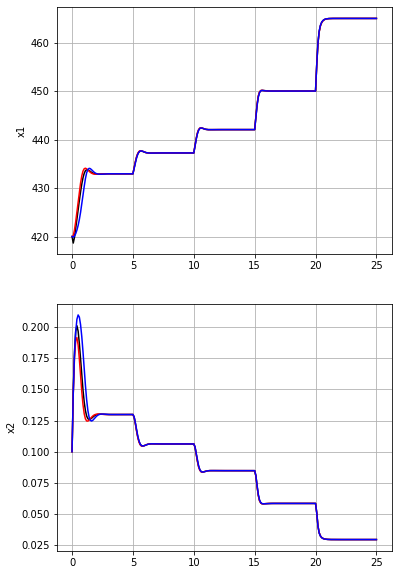

In [1102]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_linear = np.array(x_linear_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_linear = x_plot_linear[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_appr, 'k')
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_linear, 'b')
    plt.ylabel('x' + str(i + 1))

#### Test: measurement noise

In [1116]:
x_list1 = []
x_list1.append(x_init.flatten().tolist())

uk = np.array([[110]])
xk = x_init

ur_list = [110, 105, 98.9, 88.3, 68.6]
x1r_list = [432.94, 437.25, 442.07, 450.03, 465.00]
x2r_list = [0.1298, 0.1062, 0.0848, 0.0585, 0.0295]

x1_start = 420
x2_start = 0.1
u0 = np.array([[105]])


N = 50
N_len = len(step_input_list)


# for i in range(N * N_len):
#     if i % N == 0 and i != 0:
#         input_counter += 1
#     uk = step_input_list[input_counter]
#     u0 = uk
#     x_next = x_next_fn_lin(xk,xk,u0,uk)
# #     x_next = x_next_fn_lin(x0,xk,u0,uk)
# #     print(x_next)
#     x_list1.append(x_next.full().flatten().tolist())
#     x0 = xk
#     xk = x_next



### Appr
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2




x0 = np.array([[x1_start],[x2_start]])



x_appr_list = []

xk = x0
uk = u0


x_appr_list.append( xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]



input_counter = 0



for i in range(N * N_len):
    x_lin = xk
    u_lin = uk

    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])   
    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]
#     if i == 0:
#         uk = -3
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_appr_list.append(x_next.full().flatten().tolist())
    
    xk = x_next + ca.DM(np.array([[0.01,0.0001]]) @ np.random.rand(2,1))


### Real
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

x0 = np.array([[x1_start],[x2_start]])

xk = x0
uk = u0
x_real_list = []
x_real_list.append(xk.flatten().tolist())

input_counter = 0

for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])  
    
    
    p = np.vstack([xk,xr,ur])
    nl['p'] = p
    
    x_guess = [x1r_list[input_counter],x2r_list[input_counter]] * (N_pred+1) + [ur_list[input_counter]] * N_pred
    nl['x0'] = x_guess

    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_real_list.append(x_next.full().flatten().tolist())
    
    x_lin = xk
    xk = x_next + ca.DM(np.array([[0.01,0.0001]]) @ np.random.rand(2,1))
### Linear
lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)

nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg

# x1_start = np.pi/2

x0 = np.array([[x1_start],[x2_start]])

xk = x0
uk = u0


x_linear_list = []
x_linear_list.append( xk.flatten().tolist())

input_counter = 0

for i in range(N * N_len):
    if i % N == 0 and i != 0:
        input_counter += 1

    xr = np.array([[x1r_list[input_counter]],[x2r_list[input_counter]]])
    ur = np.array([[ur_list[input_counter]]])   
    x_lin = xr
    u_lin = ur    
    p = np.vstack([xk, x_lin, u_lin,xr,ur])
    nl['p'] = p

    x_guess = [x1r_list[input_counter],x2r_list[input_counter]] * (N_pred + 1) + [ur_list[input_counter]] * N_pred
    nl['x0'] = x_guess
    
    
    sol = solver_appr(**nl)
#     print("state",sol['x'].full()[:u_ind])
    print("input",sol['x'].full()[u_ind:])
    uk = sol['x'].full()[u_ind,0]

    x_next = integrator_rk4(ode,xk,uk,delta_t)
    
    x_linear_list.append(x_next.full().flatten().tolist())
    
    xk = x_next + ca.DM(np.array([[0.01,0.0001]]) @ np.random.rand(2,1))

input [[ 32.88670101]
 [ 42.31380642]
 [ 52.5432103 ]
 [ 62.6974961 ]
 [ 72.23252905]
 [ 80.86113488]
 [ 88.48199766]
 [ 95.1157168 ]
 [100.84860996]
 [105.7839677 ]]
input [[ 32.6746789 ]
 [ 58.55694644]
 [ 78.56430342]
 [ 93.40076593]
 [103.82665504]
 [110.57979958]
 [114.33180617]
 [115.67081366]
 [115.10420982]
 [113.07661791]]
input [[ 63.11109659]
 [ 90.19743997]
 [107.49796713]
 [117.81343125]
 [123.20998318]
 [125.1715665 ]
 [124.73341451]
 [122.59672746]
 [119.22745969]
 [114.94401745]]
input [[ 90.06967896]
 [109.49458209]
 [120.54719547]
 [125.98122077]
 [127.73480465]
 [127.12879486]
 [125.0302628 ]
 [121.98545307]
 [118.32855627]
 [114.27391613]]
input [[114.82033128]
 [125.40807617]
 [129.85847782]
 [130.5608698 ]
 [129.10470841]
 [126.49942087]
 [123.34858618]
 [119.98559963]
 [116.57970886]
 [113.22188208]]
input [[126.94067484]
 [131.38859879]
 [131.71822857]
 [129.75016753]
 [126.69286521]
 [123.29384143]
 [119.9725766 ]
 [116.93108402]
 [114.24317944]
 [111.92618998]

input [[113.25460714]
 [109.36874563]
 [106.64152032]
 [105.07419943]
 [104.40480565]
 [104.30365131]
 [104.48048644]
 [104.72678241]
 [104.91950823]
 [105.00822261]]
input [[113.12312171]
 [109.45203544]
 [106.77737007]
 [105.17132942]
 [104.42987538]
 [104.26128116]
 [104.39500189]
 [104.62899015]
 [104.83819473]
 [104.96418887]]
input [[109.94382141]
 [107.23112615]
 [105.50428032]
 [104.6228636 ]
 [104.33528839]
 [104.38966835]
 [104.58682676]
 [104.79474358]
 [104.94242545]
 [105.00667617]]
input [[112.54773677]
 [109.44988247]
 [107.01059069]
 [105.41805805]
 [104.58096236]
 [104.29181126]
 [104.33083508]
 [104.51861651]
 [104.73262432]
 [104.90302217]]
input [[113.02643246]
 [109.79640392]
 [107.22065293]
 [105.52095833]
 [104.61585972]
 [104.29341222]
 [104.32302328]
 [104.5135521 ]
 [104.73296826]
 [104.90560429]]
input [[115.30693175]
 [111.39190406]
 [108.11900883]
 [105.87761042]
 [104.6309121 ]
 [104.14279866]
 [104.13117242]
 [104.35187639]
 [104.63060063]
 [104.8629579 ]

input [[90.9235519 ]
 [89.69689575]
 [88.96565124]
 [88.58801012]
 [88.41671217]
 [88.34983585]
 [88.32864265]
 [88.32314484]
 [88.31937374]
 [88.31163745]]
input [[94.73142132]
 [92.43374132]
 [90.52986392]
 [89.34427747]
 [88.7221311 ]
 [88.44127858]
 [88.33537293]
 [88.30576461]
 [88.30224285]
 [88.30269187]]
input [[96.35300133]
 [93.32120557]
 [91.01368108]
 [89.63843751]
 [88.93391802]
 [88.61600316]
 [88.48812384]
 [88.43681748]
 [88.40270502]
 [88.35787388]]
input [[96.0913923 ]
 [93.00260994]
 [90.84087748]
 [89.60195645]
 [88.97807484]
 [88.69482814]
 [88.57414118]
 [88.51506175]
 [88.46317294]
 [88.39115432]]
input [[95.32083423]
 [92.45191398]
 [90.52191763]
 [89.43738398]
 [88.89772474]
 [88.6544219 ]
 [88.55063424]
 [88.49859198]
 [88.45110864]
 [88.38442763]]
input [[95.2940241 ]
 [92.47172841]
 [90.53049178]
 [89.42726827]
 [88.87533491]
 [88.62680922]
 [88.52258913]
 [88.47328209]
 [88.43136522]
 [88.3734361 ]]
input [[94.88911979]
 [92.20388597]
 [90.37697442]
 [89.34

input [[ 17.84755585]
 [ 49.03620121]
 [ 75.82743373]
 [ 95.94094653]
 [109.11891336]
 [116.26198846]
 [118.77993081]
 [118.1678394 ]
 [115.77903763]
 [112.74657864]]
input [[ 49.60436101]
 [ 74.33722696]
 [ 93.59634954]
 [106.77978465]
 [114.48015722]
 [117.85903494]
 [118.21799728]
 [116.74874949]
 [114.42453276]
 [111.98890677]]
input [[ 76.25207664]
 [ 95.24270717]
 [108.05275072]
 [115.42098603]
 [118.59596901]
 [118.91492595]
 [117.56005336]
 [115.45242713]
 [113.23982045]
 [111.33889403]]
input [[ 92.42561569]
 [107.53855889]
 [116.27895141]
 [120.11766063]
 [120.63168654]
 [119.21261386]
 [116.93563952]
 [114.53820937]
 [112.46266806]
 [110.92718655]]
input [[107.46786848]
 [118.6752386 ]
 [123.51217091]
 [124.06819151]
 [122.17267965]
 [119.22795325]
 [116.18337058]
 [113.5908268 ]
 [111.6955948 ]
 [110.53117695]]
input [[117.79112957]
 [125.71602473]
 [127.63559041]
 [125.93867025]
 [122.52097154]
 [118.71201196]
 [115.3217981 ]
 [112.7451619 ]
 [111.08002581]
 [110.23303129]

input [[114.77093654]
 [110.4391081 ]
 [107.19260985]
 [105.12857552]
 [104.06765177]
 [103.72586958]
 [103.82122782]
 [104.1261504 ]
 [104.48197935]
 [104.7911945 ]]
input [[111.41095409]
 [108.01458669]
 [105.71372873]
 [104.41537305]
 [103.87806536]
 [103.83225259]
 [104.04622151]
 [104.35157379]
 [104.64319407]
 [104.86634491]]
input [[108.4362111 ]
 [106.12261068]
 [104.7376066 ]
 [104.09171505]
 [103.94527071]
 [104.07966694]
 [104.32913214]
 [104.58641632]
 [104.79428083]
 [104.93164494]]
input [[107.05193279]
 [105.5283938 ]
 [104.65798705]
 [104.28712989]
 [104.24081546]
 [104.36707418]
 [104.5549018 ]
 [104.73534728]
 [104.87398291]
 [104.96064455]]
input [[110.27234595]
 [108.41926509]
 [106.81766877]
 [105.65630042]
 [104.94613483]
 [104.60644267]
 [104.52573468]
 [104.5978443 ]
 [104.738079  ]
 [104.88586696]]
input [[113.94408271]
 [111.15689061]
 [108.54914231]
 [106.54224819]
 [105.23470349]
 [104.54324694]
 [104.30885229]
 [104.36371625]
 [104.5647995 ]
 [104.80331647]

input [[106.51140851]
 [103.34777161]
 [100.9303803 ]
 [ 99.41150175]
 [ 98.64091436]
 [ 98.37587775]
 [ 98.39265905]
 [ 98.52910232]
 [ 98.68722753]
 [ 98.81771566]]
input [[104.43664501]
 [101.78680534]
 [ 99.96333947]
 [ 98.92982348]
 [ 98.48141646]
 [ 98.3908153 ]
 [ 98.47573594]
 [ 98.61664237]
 [ 98.74884849]
 [ 98.84539998]]
input [[82.96013228]
 [86.68337013]
 [88.17291811]
 [88.60587655]
 [88.62290106]
 [88.5236506 ]
 [88.42429189]
 [88.35627106]
 [88.31887859]
 [88.30309681]]
input [[89.88311025]
 [90.6768727 ]
 [90.15120767]
 [89.43515638]
 [88.88930132]
 [88.55770995]
 [88.38646904]
 [88.312397  ]
 [88.28956638]
 [88.29062503]]
input [[95.5245766 ]
 [93.67592841]
 [91.51863424]
 [89.94458187]
 [89.01229488]
 [88.53968924]
 [88.33684173]
 [88.27070189]
 [88.26473732]
 [88.2807228 ]]
input [[94.18877614]
 [91.86846083]
 [90.14286204]
 [89.10870798]
 [88.57859264]
 [88.34713299]
 [88.26773188]
 [88.25502294]
 [88.26656246]
 [88.28418925]]
input [[92.10677876]
 [90.3219343 ]
 [

input [[46.96558578]
 [63.8972229 ]
 [70.89364102]
 [73.13141573]
 [73.25860781]
 [72.57603427]
 [71.68168473]
 [70.81585428]
 [70.04074198]
 [69.32879102]]
input [[78.09708207]
 [77.27101928]
 [75.63651283]
 [73.95653477]
 [72.51789673]
 [71.38602678]
 [70.532723  ]
 [69.89667917]
 [69.40901807]
 [69.0006908 ]]
input [[51.64197674]
 [66.66887125]
 [72.53055021]
 [74.09439389]
 [73.82252159]
 [72.90421367]
 [71.87068334]
 [70.92225156]
 [70.09706752]
 [69.35282949]]
input [[83.4478271 ]
 [80.20206988]
 [77.21823451]
 [74.79405491]
 [72.95042542]
 [71.60182958]
 [70.63506352]
 [69.94140312]
 [69.42582687]
 [69.0050963 ]]
input [[59.26670422]
 [70.41371798]
 [74.26104181]
 [74.81278056]
 [74.05657734]
 [72.92469913]
 [71.81178295]
 [70.84756175]
 [70.03539838]
 [69.31759087]]
input [[86.06728706]
 [80.65185943]
 [76.79854918]
 [74.12038397]
 [72.29012203]
 [71.05272819]
 [70.21814323]
 [69.64754461]
 [69.23874361]
 [68.91254949]]
input [[26.19881856]
 [57.07055106]
 [70.26855141]
 [74.88

CasADi - 2021-08-16 11:43:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

input [[68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]]
input [[68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]]
input

CasADi - 2021-08-16 11:43:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 [[68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]]
input

CasADi - 2021-08-16 11:43:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 [[68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]]
input [[68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]]
input [[68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]]
input [[68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]]
input [[68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]]
input [[68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]]
input [[68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]]
input [[68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]
 [68.6]]


CasADi - 2021-08-16 11:43:33 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:33 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:33 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:33 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:33 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:33 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2021-08-16 11:43:33 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 0, col 0).")

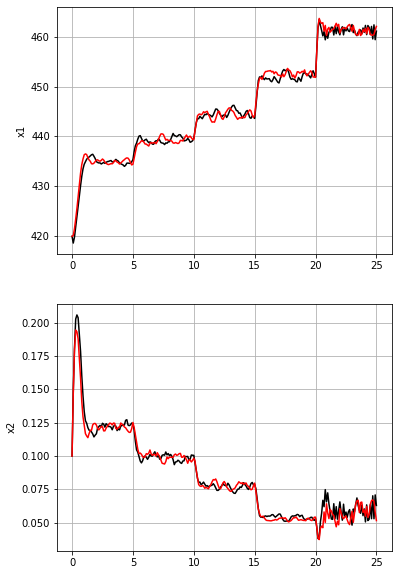

In [1121]:
x_plot_real = np.array(x_real_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_linear = np.array(x_linear_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

x_plot_appr = np.array(x_appr_list)
tgrid = [delta_t * k for k in range(N * N_len + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_opt_real = x_plot_real[:,i]
    x_opt_linear = x_plot_linear[:,i]
    x_opt_appr = x_plot_appr[:,i]
    plt.plot(tgrid, x_opt_appr, 'k')
    plt.plot(tgrid, x_opt_real, 'r')
#     plt.plot(tgrid, x_opt_linear, 'b')
    plt.ylabel('x' + str(i + 1))